In [51]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [4]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3

In [5]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
dataset=tf.keras.preprocessing.image_dataset_from_directory("PlantVillage",shuffle=True,image_size=(256,256),batch_size=32)

Found 2153 files belonging to 3 classes.


In [10]:
class_name=dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [11]:
dataset_dir="PlantVillage"

import os


# Get the number of images in each class
class_counts = {class_name: len(os.listdir(os.path.join(dataset_dir, class_name))) 
                for class_name in os.listdir(dataset_dir)}

# Print the class counts
print("Class distribution:", class_counts)

Class distribution: {'Potato___Early_blight': 1001, 'Potato___healthy': 152, 'Potato___Late_blight': 1000}


In [12]:
len(dataset)

68

In [13]:
len(dataset)*32

2176

(32, 256, 256, 3)
<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[168., 146., 148.],
        [168., 146., 148.],
        [170., 148., 150.],
        ...,
        [164., 143., 150.],
        [174., 153., 160.],
        [164., 143., 150.]],

       [[165., 143., 145.],
        [163., 141., 143.],
        [165., 143., 145.],
        ...,
        [164., 143., 150.],
        [174., 153., 160.],
        [172., 151., 158.]],

       [[173., 151., 153.],
        [170., 148., 150.],
        [170., 148., 150.],
        ...,
        [165., 144., 151.],
        [172., 151., 158.],
        [175., 154., 161.]],

       ...,

       [[ 64.,  56.,  69.],
        [ 67.,  59.,  72.],
        [ 70.,  62.,  75.],
        ...,
        [161., 138., 146.],
        [163., 140., 148.],
        [167., 144., 152.]],

       [[ 63.,  55.,  68.],
        [ 65.,  57.,  70.],
        [ 67.,  59.,  72.],
        ...,
        [164., 141., 149.],
        [163., 14

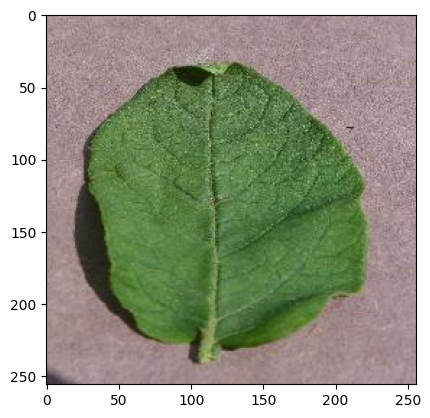

In [14]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    print(image_batch[0].numpy)
    print(label_batch.numpy())

In [15]:
train_ds=dataset.take(54)

In [16]:
len(train_ds)

54

In [17]:
54*32


1728

In [18]:
remain=dataset.skip(54)

In [19]:
val_ds=remain.take(6)

In [20]:
test_ds=remain.skip(6)

In [21]:
def get_dataset(ds,train=0.8,val=0.1,test=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)

    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)

    train_size=int(train*ds_size)
    val_size=int(val*ds_size)

    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [22]:
train_ds,val_ds,test_ds=get_dataset(dataset)

In [23]:
len(train_ds)


54

In [24]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [25]:
resize_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [26]:
data_augumentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [27]:
model=models.Sequential([
    resize_rescale,
    data_augumentation,
    layers.Conv2D(32,(3,3),activation="relu",input_shape=(256,256)),#32=features, 3,3=filter size
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dense(3,activation="softmax")
])
    

In [28]:
model.build(input_shape=(32,256,256,3))

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [30]:
model.compile(optimizer="adam",loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=["accuracy"])

0


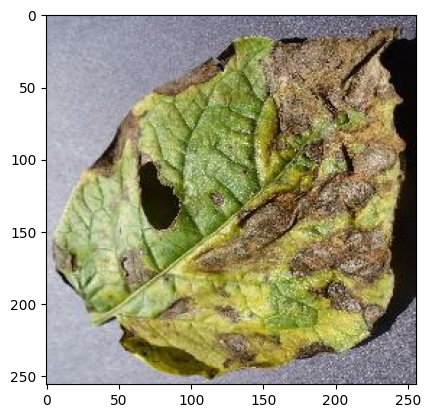

In [31]:
for i , j in train_ds.take(1):
    img=i[0].numpy().astype("uint8")
    plt.imshow(img)
    print(j[0].numpy())
    

In [33]:
for i, disease in enumerate(train_ds.class_names):
    print(f"Number {i} refers to disease: {disease}")

AttributeError: 'PrefetchDataset' object has no attribute 'class_names'

In [34]:
history=model.fit(train_ds,epochs=50,verbose=1,batch_size=BATCH_SIZE,validation_data=val_ds)

Epoch 1/50
54/54 [==============================] - 63s 341ms/step - loss: 0.9261 - accuracy: 0.4913 - val_loss: 0.8052 - val_accuracy: 0.5312
Epoch 2/50
54/54 [==============================] - 9s 168ms/step - loss: 0.7205 - accuracy: 0.6447 - val_loss: 0.5674 - val_accuracy: 0.7292
Epoch 3/50
54/54 [==============================] - 8s 140ms/step - loss: 0.5359 - accuracy: 0.7679 - val_loss: 0.3675 - val_accuracy: 0.8073
Epoch 4/50
54/54 [==============================] - 8s 152ms/step - loss: 0.3742 - accuracy: 0.8449 - val_loss: 0.4792 - val_accuracy: 0.8229
Epoch 5/50
54/54 [==============================] - 8s 154ms/step - loss: 0.3675 - accuracy: 0.8443 - val_loss: 0.1932 - val_accuracy: 0.9323
Epoch 6/50
54/54 [==============================] - 9s 167ms/step - loss: 0.2805 - accuracy: 0.8912 - val_loss: 0.1744 - val_accuracy: 0.9427
Epoch 7/50
54/54 [==============================] - 9s 161ms/step - loss: 0.2218 - accuracy: 0.9126 - val_loss: 0.1654 - val_accuracy: 0.9479
Epoch

In [35]:
scores=model.evaluate(test_ds)
scores

8/8 [==============================] - 9s 59ms/step - loss: 0.0228 - accuracy: 0.9961


[0.02276357263326645, 0.99609375]

In [36]:
history

In [37]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [38]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [39]:
acc=history.history["accuracy"]
val_acc=history.history["val_accuracy"]

loss=history.history["loss"]
val_loss=history.history["val_loss"]



Text(0.5, 1.0, 'Training and Validation Accuracy')

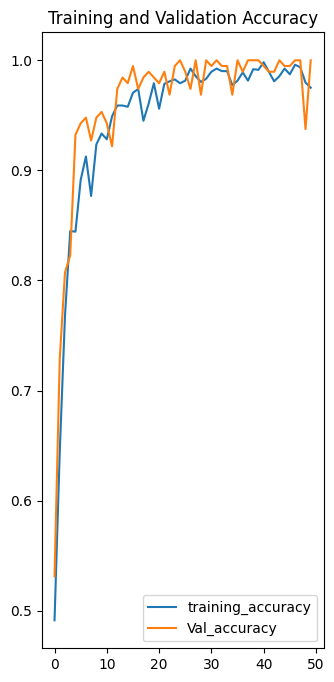

In [40]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(50),acc,label="training_accuracy")
plt.plot(range(50),val_acc,label="Val_accuracy")
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

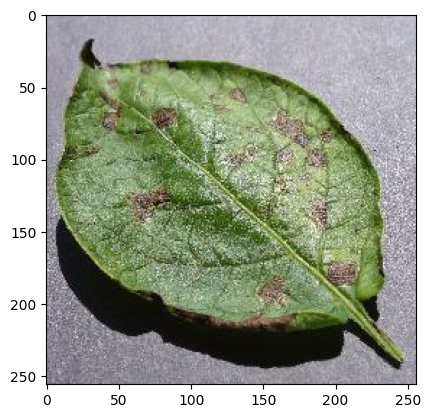

In [41]:
img=None
value=None
for i,j in test_ds.take(3):
    img=i[0].numpy().astype("uint8")
    value=j[0].numpy()
    plt.imshow(img)

In [42]:
value

0

In [43]:
pred=model.predict(train_ds.take(4))
pred

4/4 [==============================] - 1s 103ms/step


array([[6.47992238e-07, 6.10410213e-01, 3.89589131e-01],
       [4.71476618e-08, 1.17706396e-02, 9.88229275e-01],
       [1.00000000e+00, 3.43335991e-08, 8.95833096e-17],
       [9.99952435e-01, 4.75945635e-05, 6.25796429e-11],
       [7.30569809e-07, 9.99999285e-01, 2.86009012e-11],
       [3.80413374e-04, 9.99612153e-01, 7.44909039e-06],
       [9.99994159e-01, 5.81222048e-06, 1.71284528e-16],
       [9.99879599e-01, 1.20402547e-04, 1.09974608e-11],
       [9.99994159e-01, 5.83015253e-06, 1.84519067e-12],
       [1.27874819e-06, 9.99997854e-01, 7.99707436e-07],
       [1.25001939e-02, 9.87484992e-01, 1.48204599e-05],
       [1.00000000e+00, 1.73793124e-09, 3.41762781e-15],
       [1.34437531e-02, 9.86549675e-01, 6.59097032e-06],
       [2.12359335e-02, 9.78438914e-01, 3.25146888e-04],
       [5.59760025e-03, 9.93822932e-01, 5.79504063e-04],
       [2.60298228e-04, 9.99737442e-01, 2.31134823e-06],
       [1.00000000e+00, 4.46004513e-08, 6.60383985e-19],
       [3.83869883e-05, 9.99959

In [44]:
import numpy as np
predicted_classes = np.argmax(pred)

In [45]:
print(predicted_classes)

6


In [46]:
model.save("PotatoDisease.h5")

In [47]:
loaded_model=tf.keras.models.load_model("PotatoDisease.h5")

In [48]:
pred=loaded_model.predict(train_ds.take(4))

4/4 [==============================] - 0s 76ms/step


In [49]:
pred

array([[1.00000000e+00, 4.34872511e-08, 7.78426124e-17],
       [7.68651444e-05, 9.99922991e-01, 1.20485922e-07],
       [9.99737322e-01, 2.62612855e-04, 3.26436469e-13],
       [1.04889525e-02, 9.15360987e-01, 7.41499662e-02],
       [3.04981659e-04, 9.99692798e-01, 2.22534527e-06],
       [2.09561127e-04, 9.99790370e-01, 1.32423452e-07],
       [9.99977469e-01, 2.24948672e-05, 1.98513810e-11],
       [1.12309931e-06, 9.99994874e-01, 4.01392663e-06],
       [4.76396708e-05, 9.96997118e-01, 2.95519782e-03],
       [8.87922215e-05, 9.99911070e-01, 1.68344073e-07],
       [2.51274105e-05, 9.99974728e-01, 9.27570980e-08],
       [1.88115239e-02, 9.81188476e-01, 1.49383794e-08],
       [5.80333563e-07, 9.99995470e-01, 3.94525205e-06],
       [8.12051167e-06, 9.99991894e-01, 4.30946123e-08],
       [9.99984026e-01, 1.60280088e-05, 8.71136357e-11],
       [6.23263884e-04, 9.99376714e-01, 3.61495478e-09],
       [9.99999881e-01, 1.20502662e-07, 4.39708440e-15],
       [9.99995708e-01, 4.31342

In [50]:
loaded_model

In [52]:
IMG_SIZE = (256, 256)

# Open webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Display the frame
    cv2.imshow("Press 's' to capture", frame)

    # Press 's' to capture image
    key = cv2.waitKey(1) & 0xFF
    if key == ord('s'):
        img = cv2.resize(frame, IMG_SIZE)  # Resize for model input
        img_array = np.expand_dims(img, axis=0)  # Add batch dimension
        img_array = img_array / 255.0  # Normalize

        # Predict
        predictions = loaded_model.predict(img_array)
        predicted_class = np.argmax(predictions)  # Get class with highest probability

        print(f"Predicted class: {predicted_class}")

        # Show result on screen
        cv2.putText(frame, f"Class: {predicted_class}", (50, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        cv2.imshow("Prediction", frame)
        cv2.waitKey(3000)  # Display for 3 seconds

    elif key == ord('q'):  # Press 'q' to quit
        break

cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 1s 1s/step
Predicted class: 1
1/1 [==============================] - 0s 39ms/step
Predicted class: 1
